### CAPM的不足与三因子模型的诞生

CAPM模型经历了大量的实证和应用之后，有证据表明，市场风险溢酬并不能充分解释个别风险资产的收益率。于是很多研究者开始探索其他的因素，比如公司市值、PE、杠杆比例、账面市值比等。

Fama和French两个人对于各种因素进行了全面的组合分析，当单独使用Beta或者用Beta分别与其他几个因子相结合时，Beta的解释能力很弱；市值、PE（市盈率）、杠杆比例、BM（账面市值比，PB的倒数）单独来用时，对于收益率的解释能力都很强，但是组合起来时，市值、BM会弱化杠杆比例和PE的解释能力。

后来Fama和French两人提取了3个重要因子：市场风险溢酬因子、市值因子和账面市值比因子，以收益率作为因变量构建了一个类似CAPM的线性模型，即著名的三因子模型。

### 三因子模型的原理

三因子模型中的3个因子均为投资组合的收益率：市场风险溢酬因子对应了市场投资组合的收益率，市值因子对应了做多市值较小的公司与做空市值较大的公司的投资组合带来的收益率，账面市值比因子对应的是做多高BM公司、做空低BM公司的投资组合带来的收益率。三因子模型的形式为：

$$E(R_{it}) - R_{ft} = b_i[E(R_{mt}) - R_{ft}] + s_iE(SMB_t) + h_iE(HML_t)$$

可以看到这里用的是期望，所以我们仍然转换成线性回归模型的形式：

\begin{aligned} R_{it} - R_{ft} &= \alpha_i + b_i(R_{mt} - R_{ft}) + s_iSMB_t + h_iHML_t\\ \quad\\ R_{it} &: 我们要研究的投资组合或个股的收益率序列\\ R_{ft} &: 无风险收益率，比如国债的收益率序列\\ \alpha_i &: 超额收益率，是投资组合或个股在大盘波动带来的收益之外的额外收益率\\ R_{mt} &: 市场投资组合收益率序列，常用合适的大盘指数来替代\\ SMB_t &: 市值投资组合收益率序列\\ HML_t &: BM投资组合收益率序列\\ \epsilon_i&: 误差项 \end{aligned}

这样大家就比较熟悉了，一个常数项，三个自变量，一个误差项，一个因变量，妥妥的一个多元线性回归模型。跟CAPM中一样，α代表超额收益率，越高越好，说明我们的投资组合越优秀。

不要看到这么多名词就害怕，在实际应用过程中，这些数据都是已知的，我们直接把数据扔给计算机，通过最小二乘法求解得到α、b、s、h的估计值即可以及它们是否显著即可。

唯一稍显麻烦一点的是SMB和HML的计算，这一部分需要先根据流通市值将股票分为1：1的大市值（B）和小市值（S)股票；根据BM数据将股票分为3：4：3的高中低（H/M/L）三组；这样我们就有了2×3共计6种投资组合（SL/SM/SH/BL/BM/BH）。然后我们通过市值加权平均的方式求得各组的收益率，最后就是求SMB和HML了：

 $$SMB_t = \frac{1}{3}(SL_t + SM_t + SH_t) - \frac{1}{3}(BL_t+BM_t+BHt)\\ HML_t = \frac{1}{2}(SH_t + BH_t) - \frac{1}{2}(SL_t + BL_t)$$ 

写再多公式都不如直接用Python实战演练一下。

### Python三因子模型选股实战

#### 计算SMB和HML
导入必要的库

In [10]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
sns.set()
#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
#使用tushare获取数据
import tushare as ts
token='输入你的token'
pro = ts.pro_api()

定义计算函数

In [2]:
def cal_smb_hml(df):
    # 划分大小市值公司
    df['SB'] = df['circ_mv'].map(lambda x: 'B' if x >= df['circ_mv'].median() else 'S')
    # 求账面市值比：PB的倒数
    df['BM'] = 1 / df['pb']
    # 划分高、中、低账面市值比公司
    border_down, border_up = df['BM'].quantile([0.3, 0.7])
    border_down, border_up
    df['HML'] = df['BM'].map(lambda x: 'H' if x >= border_up else 'M')
    df['HML'] = df.apply(lambda row: 'L' if row['BM'] <= border_down else row['HML'], axis=1)
    # 组合划分为6组
    df_SL = df.query('(SB=="S") & (HML=="L")')
    df_SM = df.query('(SB=="S") & (HML=="M")')
    df_SH = df.query('(SB=="S") & (HML=="H")')
    df_BL = df.query('(SB=="B") & (HML=="L")')
    df_BM = df.query('(SB=="B") & (HML=="M")')
    df_BH = df.query('(SB=="B") & (HML=="H")')
    # 计算各组收益率
    R_SL = (df_SL['pct_chg'] * df_SL['circ_mv'] / 100).sum() / df_SL['circ_mv'].sum()
    R_SM = (df_SM['pct_chg'] * df_SM['circ_mv'] / 100).sum() / df_SM['circ_mv'].sum()
    R_SH = (df_SH['pct_chg'] * df_SH['circ_mv'] / 100).sum() / df_SH['circ_mv'].sum()
    R_BL = (df_BL['pct_chg'] * df_BL['circ_mv'] / 100).sum() / df_BL['circ_mv'].sum()
    R_BM = (df_BM['pct_chg'] * df_BM['circ_mv'] / 100).sum() / df_BM['circ_mv'].sum()
    R_BH = (df_BH['pct_chg'] * df_BH['circ_mv'] / 100).sum() / df_BH['circ_mv'].sum()
    # 计算SMB, HML并返回
    smb = (R_SL + R_SM + R_SH - R_BL - R_BM - R_BH) / 3
    hml = (R_SH + R_BH - R_SL - R_BL) / 2
    return smb, hml

计算并存储数据

In [3]:
data = []
df_cal = pro.trade_cal(start_date='20170101', end_date='20190110')
df_cal = df_cal.query('(exchange=="SSE") & (is_open==1)')
for date in df_cal.cal_date:
    df_daily = pro.daily(trade_date=date)
    df_basic = pro.daily_basic(trade_date=date)
    df = pd.merge(df_daily, df_basic, on='ts_code', how='inner')
    smb, hml = cal_smb_hml(df)
    data.append([date, smb, hml])
    print(date, smb, hml)

df_tfm = pd.DataFrame(data, columns=['trade_date', 'SMB', 'HML'])
df_tfm['trade_date'] = pd.to_datetime(df_tfm.trade_date)
df_tfm = df_tfm.set_index('trade_date')
df_tfm.to_csv('df_three_factor_model.csv')
df_tfm.head()

20170103 0.003139924772218058 0.0037708752482534164
20170104 5.462766491663081e-05 -0.006751937397132092
20170105 -0.00045502858390889965 0.003886687181721766
20170106 -0.003628165662616601 0.007852493279608437
20170109 0.0001890069931952702 0.004071999968610431
20170110 -7.562845358979134e-05 -0.001551241703097866
20170111 -0.003820510347059924 0.0008778577701716809
20170112 -0.0028063182475364028 0.0006545155702352636
20170113 -0.014350446865816045 0.007862439069125596
20170116 -0.034909166510503846 0.018024248193295313
20170117 0.004673635080804113 -0.011497511614286396
20170118 -0.007423151372601019 0.0029519149339360526
20170119 -0.0010346180587035376 -0.0014553009872192615
20170120 0.008982838129276187 -0.004876145529070418
20170123 0.006169097449166075 -0.0010893333062417876
20170124 -0.0035854209441442153 0.007009932282060191
20170125 0.0019358341381901798 -0.002704892248107606
20170126 0.001119372652597161 -0.0021634085848875263
20170203 0.00021779807663625602 -0.0048585100257

,SMB,HML
trade_date,,
2017-01-03,0.003140,0.003771
2017-01-04,0.000055,-0.006752
2017-01-05,-0.000455,0.003887
2017-01-06,-0.003628,0.007852
2017-01-09,0.000189,0.004072


根据我实际测试，计算两年的数据大概要七八分钟，我们可以把历史数据整个计算一遍，存到本地或者数据库中，以后就可以直接调用了。偷懒的同学也可以私信我，我会提供我已经计算好的数据给大家。毕竟这两种组合的收益率的计算不是我们这节的重点。

#### 挑选股票和基准指数
还是以这几只股票为例，不过这几只股票可能太有代表性，跟指数的波动形态比较接近，在大家自己练手的时候，推荐选择不同市值水平、PB水平的股票来测试，我们这里只讲解方法。

In [5]:
# 获取数据
wanke = pro.daily(ts_code='000002.SZ', start_date='20170101', end_date='20190110')
pingan = pro.daily(ts_code='601318.SH', start_date='20170101', end_date='20190110')
maotai = pro.daily(ts_code='600519.SH', start_date='20170101', end_date='20190110')
wanhua = pro.daily(ts_code='002415.SZ', start_date='20170101', end_date='20190110')
keda = pro.daily(ts_code='002230.SZ', start_date='20170101', end_date='20190110')
gzA = pro.index_daily(ts_code='399317.SZ', start_date='20170101', end_date='20190110')

# 仅保留收益率数据，且用日期作为index
# 然后按照日期排序（增序）
stock_list = [wanke, pingan, maotai, wanhua, keda, gzA]
for stock in stock_list:
    stock.index = pd.to_datetime(stock.trade_date)
df_stock = pd.concat([stock.pct_chg / 100 for stock in stock_list], axis=1)
df_stock.columns = ['wanke', 'pingan', 'maotai', 'wanhua', 'keda', 'gzA']
df_stock = df_stock.sort_index(ascending=True)
df_stock.head()
#这里geA是指国证A股指数，更能代表整个A股市场。

,wanke,pingan,maotai,wanhua,keda,gzA
trade_date,,,,,,
2017-01-03,0.0088,0.0071,0.0012,0.0181,0.0111,0.009550
2017-01-04,0.0058,-0.0008,0.0519,-0.0033,0.0230,0.009949
2017-01-05,0.0038,0.0022,-0.0147,0.0058,0.0036,0.000105
2017-01-06,-0.0139,-0.0081,0.0116,-0.0082,-0.0117,-0.006683
2017-01-09,0.0010,-0.0006,-0.0064,0.0066,0.0054,0.004816


整合数据，并简单探索

In [6]:
df = pd.merge(df_stock, df_tfm, left_index=True, right_index=True, how='inner')
df = df.fillna(0)
rf = 1.032 ** (1/360) - 1
df = df - rf
df2 = df.copy()
df = df['20180101':]
df.head()

,wanke,pingan,maotai,wanhua,keda,gzA,SMB,HML
trade_date,,,,,,,,
2018-01-02,0.048212,0.037212,0.009012,0.003212,0.024112,0.012332,-0.005388,0.002750
2018-01-03,-0.007188,-0.022388,0.017012,0.012912,0.023512,0.007269,0.001037,-0.002171
2018-01-04,0.024312,0.002912,0.029512,0.021612,0.015112,0.003659,-0.008058,-0.004913
2018-01-05,0.049412,-0.004188,0.001712,-0.017888,-0.015788,0.001054,0.000352,0.006564
2018-01-08,0.035312,-0.012488,0.018512,0.025512,-0.011188,0.003654,-0.005773,0.002077


观察数据间的相关性

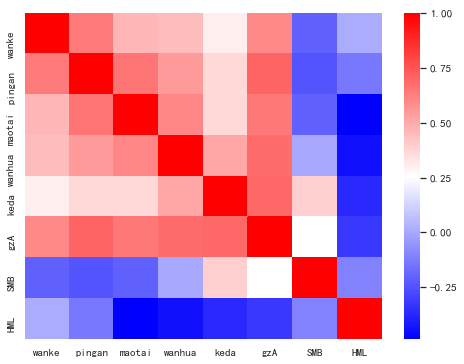

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap='bwr');

收益率时序图

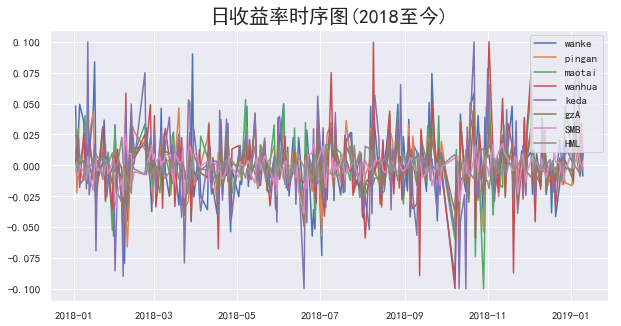

In [15]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(10, 5))
for col in df.columns:
    plt.plot(df[col], label=col)
plt.title('日收益率时序图(2018至今)', fontsize=20)
plt.legend();

累计收益率时序图

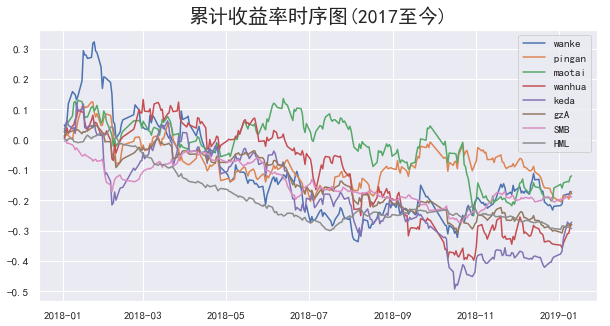

In [16]:
plt.figure(figsize=(10, 5))
for col in df.columns:
    plt.plot((df[col]+1).cumprod()-1, label=col)
plt.title('累计收益率时序图(2017至今)', fontsize=20)
plt.legend();

多元线性方程求解

求解过程如下，这次我就不帮大家解读结果了，大家尝试着自己来理解一下。

我提供一些提示，x1、x2、x3分别对应了市场风险溢酬因子、市值因子、账面市值比因子，const对应着常数项，即超额收益率α。

一般情况下，当p值小于0.05时，我们认为该因子对于收益率有显著影响。

In [28]:
#类似R语言的统计模型库statsmodels接口
import statsmodels.api as sm

stock_names = {
    'wanke': '万科A',
    'pingan': '中国平安',
    'maotai': '贵州茅台',
    'wanhua': '万华化学',
    'keda': '科大讯飞'
}
params=pd.DataFrame()
for stock in ['wanke', 'pingan', 'maotai', 'wanhua', 'keda']:
    model = sm.OLS(df[stock], sm.add_constant(
        df[['gzA', 'SMB', 'HML']].values))
    result = model.fit()
    params[stock_names[stock]]=result.params
    print(stock_names[stock] + '\n')
    print(result.summary())
    print('\n\n')

万科A

                            OLS Regression Results                            
Dep. Variable:                  wanke   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     100.1
Date:                Mon, 27 May 2019   Prob (F-statistic):           2.30e-42
Time:                        12:14:16   Log-Likelihood:                 652.67
No. Observations:                 250   AIC:                            -1297.
Df Residuals:                     246   BIC:                            -1283.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.397    

In [42]:
params.index=['Alpha','市场因子','规模因子','价值因子']
params

,万科A,中国平安,贵州茅台,万华化学,科大讯飞
Alpha,0.001634,0.000541,-0.001070,-0.001080,0.000468
市场因子,1.503772,1.236709,1.058508,1.292471,1.282314
规模因子,-1.087136,-0.946713,-0.969390,-0.559721,0.719117
价值因子,0.799829,0.246178,-0.982358,-0.930334,-0.616094


In [48]:
#将Alpha*100
params.loc['Alpha']=params.loc['Alpha']*100
params

,万科A,中国平安,贵州茅台,万华化学,科大讯飞
Alpha,0.163402,0.054117,-0.106965,-0.107975,0.046773
市场因子,1.503772,1.236709,1.058508,1.292471,1.282314
规模因子,-1.087136,-0.946713,-0.969390,-0.559721,0.719117
价值因子,0.799829,0.246178,-0.982358,-0.930334,-0.616094


In [61]:
from pyecharts import Bar
bar = Bar("个股收益归因分析",width=800, height=450,title_text_size=15,)
bar.add("万科A",params.index ,params['万科A'].round(3) ,is_splitline_show=False,)
bar.add("中国平安",params.index ,params['中国平安'].round(3) ,
      is_splitline_show=False,)
bar.add("贵州茅台",params.index ,params['贵州茅台'].round(3) ,
       is_splitline_show=False,)

bar.add("万华化学",params.index ,params['万华化学'].round(3) ,
       is_splitline_show=False,)
bar.add("科大讯飞",params.index ,params['科大讯飞'].round(3) ,
       is_splitline_show=False,)
bar

### 使用三因子构建交易策略

策略基本原理：根据Fama-French三因子模型，市场因子（市场风险溢价）、规模因子（市值）、价值因子（账面市值比）能很好地解释个股的超额收益，那么Alpha的长期均值应为0。假如某个短期内个股收益率对这三因素进行回归，得到alpha<0（即截距小于0），说明这段时间个股收益率偏低。根据有效市场假设，任何非理性的价格最终都会回归理性，这些短期内收益率偏低的个股，最终会涨回去。于是可以根据三因素模型构建一个选股组合并进行历史回测。
策略思路：  
- 设置调仓评率，比如每月月末进行调仓；
- 排除掉st股、次新股、无法交易股（如涨幅超过8.5%、停牌等）；
- 调仓日对过去250个交易日数据进行回归分析，因变量为个股收益率（Ri）,自变量为三因子：Rm（市场指数）、SMB、HML（见前文分析）；
- 获取每个回归结果的截距项，即alpha值，将alpha值最小的10只股票加入选股组合
- 对回测期间股票组合的收益、风险进行回测分析。